In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    _path = os.getcwd().replace("/notebooks", "")
else:
    assert os.getcwd().endswith("receipts-xyz-python")
    _path = os.getcwd()

if _path not in sys.path:
    sys.path.append(_path)

In [106]:
from datetime import datetime

import pandas as pd

from receipts_xyz.v2.onchainsummer import get_onchainsummer_workouts


workouts = get_onchainsummer_workouts()
df = pd.DataFrame([_w.to_json() for _w in workouts])
# df["time"] = df["time"].map(lambda x: datetime.fromtimestamp(x))
# df = df.set_index("time")

use_col = [
    "time",
    "total_participants", "total_moving_time", "total_run_distance", 
    "total_bike_distance", "total_strength_time", "total_intensity_time"
]
df = df[use_col]

In [77]:
df.to_csv("onchainsummer.csv")

In [116]:
from datetime import datetime

import matplotlib.pyplot as plt
import pytz

df["datetime"] = df["time"].map(lambda x: datetime.fromtimestamp(x, pytz.timezone("US/Eastern")))
df['hour'] = df['datetime'].dt.floor('H')

/var/folders/k6/ghkr3v6s1y3cb_pq2tf1jlxr0000gn/T/ipykernel_26985/3157458066.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['datetime'].dt.floor('H')


[]

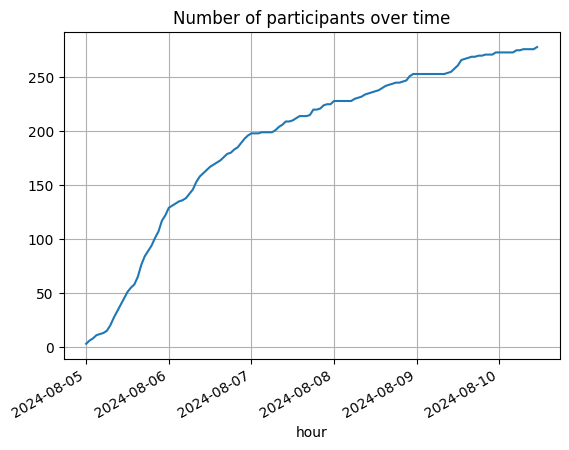

In [119]:
df.set_index("hour")["total_participants"].plot(title="Number of participants over time")
plt.grid()
plt.plot()

Accumulated intensity time: 49,653.38 / 50,000 (99.31%)


[]

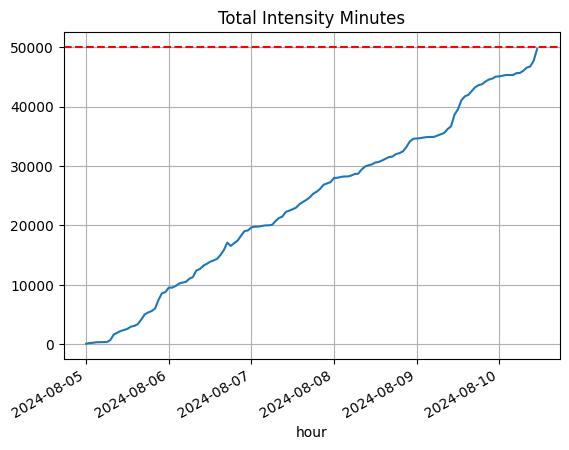

In [139]:
accumulated_intensity_minutes = df["total_intensity_time"].values[0]/60
print(f'Accumulated intensity time: {accumulated_intensity_minutes:,.2f} / 50,000 ({accumulated_intensity_minutes*100/50000:.2f}%)')

(df.set_index("hour")["total_intensity_time"] // 60).plot(title="Total Intensity Minutes")
plt.axhline(50_000, color="red", linestyle="--")
plt.grid()
plt.plot()

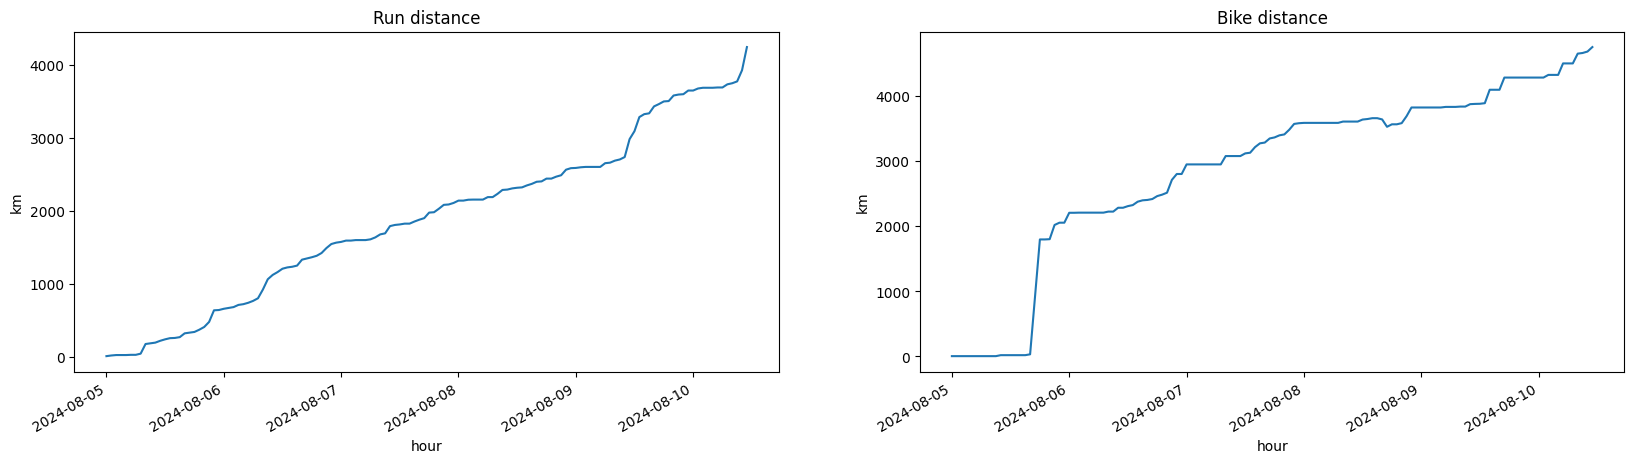

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
(df.set_index("hour")["total_run_distance"] // 1_000).plot(ax=ax[0])
(df.set_index("hour")["total_bike_distance"] // 1_000).plot(ax=ax[1])
ax[0].set_title("Run distance")
ax[1].set_title("Bike distance")
ax[0].set_ylabel("km")
ax[1].set_ylabel("km")
plt.show()

<Axes: title={'center': 'Strength time'}, xlabel='hour'>

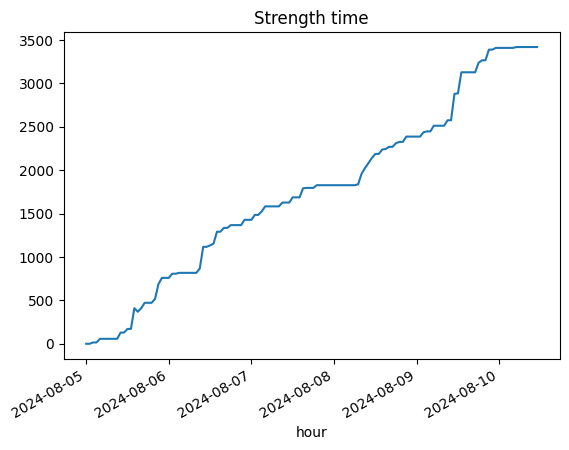

In [143]:
(df.set_index("hour")["total_strength_time"] // 60).plot(title="Strength time")

In [157]:
df[["datetime", "total_moving_time", "total_strength_time", "total_intensity_time"]].set_index("datetime")

,total_moving_time,total_strength_time,total_intensity_time
datetime,,,
2024-08-10 11:51:09-04:00,5289143,205161,2979203
2024-08-10 10:51:07-04:00,5130276,205161,2861179
2024-08-10 09:51:09-04:00,5062264,205161,2803672
2024-08-10 08:51:09-04:00,5037064,205161,2792053
2024-08-10 07:51:09-04:00,4997598,205161,2761051
...,...,...,...
2024-08-05 03:51:07-04:00,7521,950,21563
2024-08-05 02:51:07-04:00,6862,950,16487
2024-08-05 01:51:11-04:00,5912,0,13826


In [152]:
df["total_intensity_time"] / (df["total_moving_time"] + df["total_strength_time"])

0      0.542235
1      0.536260
2      0.532266
3      0.532608
4      0.530690
         ...   
140    2.545508
141    2.110471
142    2.338633
143    2.338633
144    2.245987
Length: 145, dtype: float64

<Axes: >

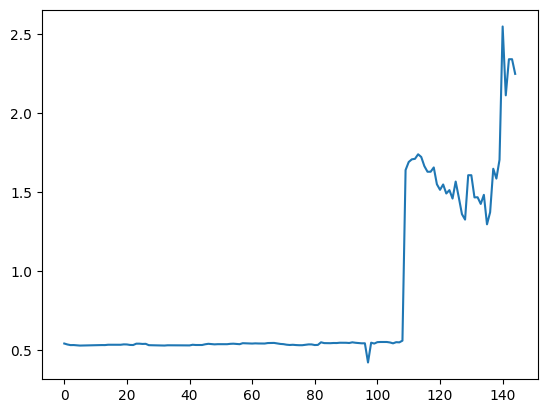

In [151]:
().plot()

0      2979203
1      2861179
2      2803672
3      2792053
4      2761051
        ...   
140      21563
141      16487
142      13826
143      13826
144       6437
Name: total_intensity_time, Length: 145, dtype: int64